In [1]:
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException, ElementNotInteractableException, TimeoutException
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import csv
from bs4 import BeautifulSoup

## Perform scraping for reviews then applying sentiment analysis


### Functions for scraping 


In [2]:
def get_review_in_page(review_data):
    review_elements = driver.find_elements(By.CSS_SELECTOR, "div.a-section.review.aok-relative")

    # Loop through each review element and print its text content
    for review in review_elements:
        # print(review.text)
        try:
            review_date = review.find_element(By.CSS_SELECTOR, "span.review-date").text
            rating_element = review.find_element(By.CSS_SELECTOR,  "i.a-icon-star span.a-icon-alt")

            # Get the rating text
            rating = rating_element.get_attribute("innerHTML")
            review_element = review.find_element(By.CLASS_NAME, 'review-title-content')
            review_text_1 = review_element.find_element(By.TAG_NAME, 'span').text.strip()     
            review_text_2 = review.find_element(By.CSS_SELECTOR, "span.review-text-content").text


            # Check if it's a verified purchase
            verified_purchase_element = review.find_elements(By.CSS_SELECTOR, "span[data-hook='avp-badge']")
            verified_purchase = "Verified Purchase" if verified_purchase_element else "Not Verified Purchase"

            review_info = {
                "Review Date": review_date,
                "Star Rating": rating,
                "Review Text": review_text_1 + ' ' + review_text_2,
                "Verified Purchase": verified_purchase
            }
            
            review_data.append(review_info)

        except NoSuchElementException as e:
            print(' ')

        try:
            review_date = review.find_element(By.CSS_SELECTOR, "span.review-date").text
            rating_element = review.find_element(By.CSS_SELECTOR, "i.a-icon-star span.a-icon-alt")

            # Get the rating text
            rating = rating_element.get_attribute("innerHTML")
            review_text_1 = review.find_element(By.CSS_SELECTOR, 'span.review-title-content').text
            review_text_2 = review.find_element(By.CSS_SELECTOR, "span.review-text-content").text


            # Check if it's a verified purchase
            verified_purchase_element = review.find_elements(By.CSS_SELECTOR, "span[data-hook='avp-badge']")
            verified_purchase = "Verified Purchase" if verified_purchase_element else "Not Verified Purchase"

            review_info = {
                "Review Date": review_date,
                "Star Rating": rating,
                "Review Text": review_text_1 + ' ' + review_text_2,
                "Verified Purchase": verified_purchase
            }
            
            review_data.append(review_info)

        except NoSuchElementException as e:
            print("Fixed", e)


    
def get_reviews(url):
    driver.get(url)
    
    try:
        result = driver.find_element(By.XPATH, '//*[@id="cm-cr-dp-review-header"]/h3/span')

        text = result.text
        print(text)
        if text == 'No customer reviews':
            return text
    except NoSuchElementException:
        result = True
        print('Text for no customer review not found')
    
    if result:
        link = driver.find_element(By.XPATH, "//a[@data-hook='see-all-reviews-link-foot' and contains(text(), 'See more reviews')]")  
        link.click()
        
        try: 
            wait = WebDriverWait(driver, 10)
            translate_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//a[@id="a-autoid-8-announce" and contains(text(), "Translate all reviews to English")]')))    
            translate_button.click()
        except (NoSuchElementException, ElementNotInteractableException, TimeoutException):
            print('Translate Button not available')

        next_page_enabled = True
        review_data = []
        while next_page_enabled:
            try:
                get_review_in_page(review_data)
                next_page_button = driver.find_element(By.XPATH, "//li[@class='a-last']//a[contains(text(), 'Next page')]")
                
                if 'a-disabled' in next_page_button.get_attribute('class'):
                    next_page_enabled = False
                else:
                    next_page_button.click()
                    time.sleep(2)  
                
            except NoSuchElementException:
                next_page_enabled = False

        print(review_data)
        return review_data

### Functions for sentiment

In [3]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import pandas as pd
from tqdm.notebook import tqdm


MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'

tokeniser = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def sentiment(text):
    encoded_text = tokeniser(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2],
    }

    return scores_dict

def sentiment_add_to_df(scores_dict, reviews_df):
    res= {}

    for i, row in tqdm(reviews_df.iterrows(), total=len(reviews_df)):
        try:
            text = row['Text']
            idno = row['Id']
            roberta_result  = sentiment(text)
            res[idno] = roberta_result
        except RuntimeError:
            print(f'Error (too long on index {idno})')

    results_df = pd.DataFrame(res).T
    results_df = results_df.reset_index().rename(columns={'index': 'Id'})
    results_df = results_df.merge(reviews_df, how='left')

    return results_df

In [12]:
temp_dict = sentiment('I hate Cherries')

In [16]:
temp_dict

{'roberta_neg': 0.9694565,
 'roberta_neu': 0.025779093,
 'roberta_pos': 0.0047643697}

In [15]:
def get_advanced_sentiment(roberta_neg, roberta_neu, roberta_pos, threshold=0.1):
    # Calculate the intensity difference between positive and negative
    intensity = roberta_pos - roberta_neg
    
    # Check if any sentiment is above a certain threshold
    if roberta_pos > threshold and intensity > 0:
        return 'Positive 😁', intensity
    elif roberta_neg > threshold and intensity < 0:
        return 'Negative', intensity
    elif roberta_neu > threshold:
        return 'Neutral', intensity
    else:
        return 'Mixed', intensity

# Example usage
roberta_neg = 0.029176002
roberta_neu = 0.5004252
roberta_pos = 0.4703988

# Get the overall sentiment and its intensity
overall_sentiment, intensity = get_advanced_sentiment(roberta_neg, roberta_neu, roberta_pos)
print(f"The overall sentiment is: {overall_sentiment} with an intensity of {intensity}")


The overall sentiment is: Positive 😁 with an intensity of 0.441222798


## Function for text preprocessing



In [4]:
import re
import string
import emoji

def clean_text(text):
    # Remove characters following "@" symbols
    text = re.sub(r'@\S+', '', text)
    
    # Convert emojis to text 
    text = emoji.demojize(text, delimiters=("", "")) 

    # Remove HTML tags and entities
    text = re.sub('<.*?>', '', text)
    text = re.sub('&[a-zA-Z0-9]+;', ' ', text)

    # Remove digits and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove underscores
    text = text.replace('_', ' ')

    # Normalize whitespace and convert to lowercase
    text = ' '.join(text.split()).lower()

    return text

### Test with sample df of urls




In [5]:
def get_sentiment_from_url(url, preprocessed):
    reviews = get_reviews(url)
    sentiment_scores = []
    if preprocessed:
        for review in reviews:
            review_text = review.get("Review Text")

            processed_text = clean_text(review_text)
            scores = sentiment(processed_text)

            scores['Pre-processed Review Text'] = processed_text  


            stars = review.get("Star Rating")
            scores['Star Rating'] = stars     

            sentiment_scores.append(scores)
            
        sentiment_df = pd.DataFrame(sentiment_scores)
        return sentiment_df
    
    else:
        for review in reviews:
            review_text = review.get("Review Text")

            scores = sentiment(review_text)

            scores['Review Text'] = review_text  


            stars = review.get("Star Rating")
            scores['Star Rating'] = stars     

            sentiment_scores.append(scores)
            
        sentiment_df = pd.DataFrame(sentiment_scores)
        return sentiment_df

    return None

In [9]:
url = 'https://www.amazon.sg/ASUS-Zenbook-Pro-14-5-UX8402VV-PS96T/dp/B0BZ63RTZD/ref=sr_1_30?qid=1700470487&s=electronics&sr=1-30'
driver = webdriver.Chrome()
#sentiment_df_nonpreprocessed = get_sentiment_from_url(url, preprocessed=False)
sentiment_df_preprocessed = get_sentiment_from_url(url, preprocessed=True)
driver.quit()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Text for no customer review not found
[{'Review Date': 'Reviewed in the United States on 14 September 2023', 'Star Rating': '5.0 out of 5 stars', 'Review Text': ' This laptop is incredible, because of its design, power and above all versatility, which allows you to place the taskbar of any design program at the bottom, above the keyboard to be able to use the entire screen only for design.', 'Verified Purchase': 'Verified Purchase'}, {'Review Date': 'Reviewed in the United States on 14 September 2023', 'Star Rating': '5.0 out of 5 stars', 'Review Text': 'Incredible laptop with an excellent quality dual screen This laptop is incredible, because of its design, power and above all versatility, which allows you to place the taskbar of any design program at the bottom, above the keyboard to be able to use the entire screen only for design.', 'Verified Purchase': 'Verified Purchase'}, {'Review Date': 'Reviewed in the United States on 6 August 2023', 'Star Rating': '4.0 out of 5 stars', 'Revi

In [7]:
# Before Text Pre-processing
sentiment_df_nonpreprocessed

,roberta_neg,roberta_neu,roberta_pos,Review Text,Star Rating
0,0.076205,0.183587,0.740208,Love the size and the technology in it which ...,4.0 out of 5 stars
1,0.009051,0.094956,0.895993,Love the size and weight,5.0 out of 5 stars
2,0.298709,0.380807,0.320484,"On 19 Jul 2023, I contacted Amazon to ask why...",4.0 out of 5 stars
3,0.033544,0.398474,0.567982,fast delivery,5.0 out of 5 stars
4,0.004063,0.050631,0.945306,I've been wanting a Kindle for 2 years or so ...,5.0 out of 5 stars
5,0.002674,0.027822,0.969504,have been reading kindle on iphone and Mac fo...,5.0 out of 5 stars
6,0.001428,0.033173,0.965399,"The perfect ebook reader, this is my 2nd Kind...",5.0 out of 5 stars
7,0.001372,0.008698,0.989930,Play Video\n Thank you for this purchase. I g...,5.0 out of 5 stars
8,0.002530,0.056490,0.940980,Best e-book in the market right now for an en...,5.0 out of 5 stars
9,0.003832,0.056458,0.939711,I bought this after as my previous kindle has...,5.0 out of 5 stars


In [10]:
# after text correction
sentiment_df_preprocessed

,roberta_neg,roberta_neu,roberta_pos,Pre-processed Review Text,Star Rating
0,0.002574,0.021639,0.975787,this laptop is incredible because of its desig...,5.0 out of 5 stars
1,0.002283,0.017683,0.980034,incredible laptop with an excellent quality du...,5.0 out of 5 stars
2,0.747168,0.206310,0.046522,incorrect information this is a pretty good pr...,4.0 out of 5 stars
3,0.747168,0.206310,0.046522,incorrect information this is a pretty good pr...,4.0 out of 5 stars
4,0.066014,0.321264,0.612722,review and score strictly related to my experi...,5.0 out of 5 stars
5,0.066014,0.321264,0.612722,review and score strictly related to my experi...,5.0 out of 5 stars
6,0.099701,0.218763,0.681536,perfect for creatives and design professionals...,5.0 out of 5 stars
7,0.099701,0.218763,0.681536,perfect for creatives and design professionals...,5.0 out of 5 stars
8,0.013074,0.144647,0.842279,exceptional well rounded laptoptablet after a ...,5.0 out of 5 stars
9,0.013074,0.144647,0.842279,exceptional well rounded laptoptablet after a ...,5.0 out of 5 stars


## Functions for visualisations for sentiment


In [102]:
import matplotlib.pyplot as plt

def plot_sentiment_bar_chart(average_neg_sentiment, average_neu_sentiment, average_pos_sentiment):
    # Sentiment categories
    categories = ['Negative', 'Neutral', 'Positive']
    
    # Average sentiment scores
    sentiments = [average_neg_sentiment, average_neu_sentiment, average_pos_sentiment]
    
    # Creating the bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(categories, sentiments, color=['red', 'gray', 'green'])
    
    # Adding labels and title
    plt.xlabel('Sentiment Category')
    plt.ylabel('Average Sentiment Score')
    plt.title('Average Sentiment Scores')

    # Displaying the plot
    plt.show()

def get_mean_of_sentiments(sentiment_df):
    average_neg_sentiment = sentiment_df['roberta_neg'].mean()
    average_neu_sentiment = sentiment_df['roberta_neu'].mean()
    average_pos_sentiment = sentiment_df['roberta_pos'].mean()

    print("Average Negative Sentiment:", average_neg_sentiment)
    print("Average Neutral Sentiment:", average_neu_sentiment)
    print("Average Positive Sentiment:", average_pos_sentiment)
    plot_sentiment_bar_chart(average_neg_sentiment, average_neu_sentiment, average_pos_sentiment)

import seaborn as sns

def scatterplot_scores_by_stars(sentiment_df):
    # Extracting necessary columns
    stars = sentiment_df['Star Rating']
    positive_scores = sentiment_df['roberta_pos']
    neutral_scores = sentiment_df['roberta_neu']
    negative_scores = sentiment_df['roberta_neg']

    # Sorting the data by stars (ascending order)
    sorted_indices = stars.argsort()
    stars_sorted = stars.iloc[sorted_indices]
    positive_scores_sorted = positive_scores.iloc[sorted_indices]
    neutral_scores_sorted = neutral_scores.iloc[sorted_indices]
    negative_scores_sorted = negative_scores.iloc[sorted_indices]

    # Creating a DataFrame for plotting
    data = pd.DataFrame({
        'Stars': stars_sorted,
        'Positive Sentiment': positive_scores_sorted,
        'Neutral Sentiment': neutral_scores_sorted,
        'Negative Sentiment': negative_scores_sorted
    })

    # Melt the DataFrame to facilitate visualization
    melted_data = data.melt(id_vars='Stars', var_name='Sentiment', value_name='Scores')

    # Plotting using Seaborn
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=melted_data, x='Stars', y='Scores', hue='Sentiment', palette=['green', 'blue', 'red'], alpha=0.7)
    plt.title('Sentiment Scores based on Number of Stars')
    plt.xlabel('Number of Stars')
    plt.ylabel('Sentiment Scores')
    plt.legend(title='Sentiment', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.)
    plt.grid(True)
    plt.grid(True)
    plt.show()



Average Negative Sentiment: 0.10613623
Average Neutral Sentiment: 0.12406202
Average Positive Sentiment: 0.76980174


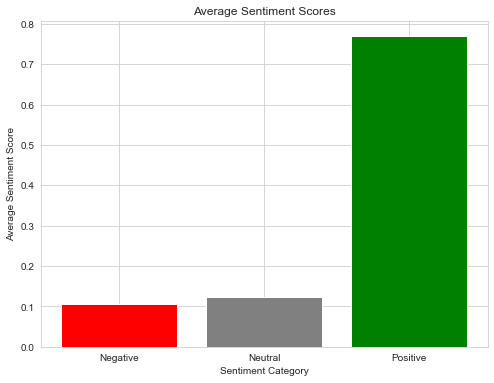

In [103]:
get_mean_of_sentiments(sentiment_df)

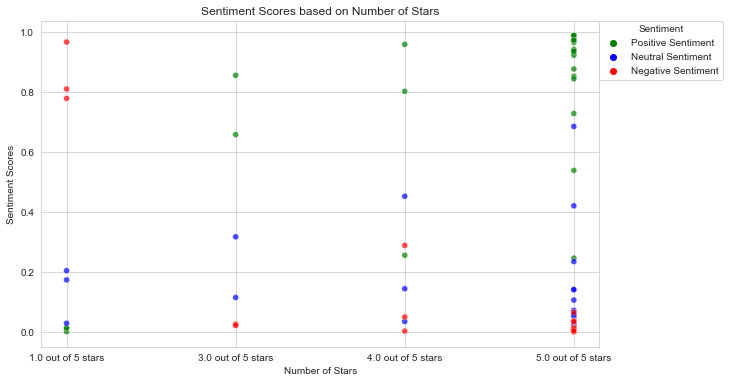

In [104]:
scatterplot_scores_by_stars(sentiment_df)

In [1]:
import selenium

print("Selenium version:", selenium.__version__)

Selenium version: 4.15.2


In [126]:
%pip install --upgrade selenium

Note: you may need to restart the kernel to use updated packages.
